In [1]:
%matplotlib inline
import keras
from keras import backend as K
import scipy
import skimage
import skimage.transform
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import imageio
import tqdm
import tensorflow as tf

Using TensorFlow backend.


In [2]:
def bgr_to_yiq(x):
    transform = np.asarray([[0.114, 0.587, 0.299], [-0.322, -0.274, 0.596], [0.312, -0.523, 0.211]], dtype=np.float32)
    h, w, c = x.shape
    x = x.transpose((2, 0, 1)).reshape((c, -1))
    x = transform.dot(x)
    return x.reshape((c, h, w)).transpose((1, 2, 0))

def yiq_to_bgr(x):
    transform = np.asarray([[1, -1.106, 1.703], [1, -0.272, -0.647], [1, 0.956, 0.621]], dtype=np.float32)
    h, w, c = x.shape
    x = x.transpose((2, 0, 1)).reshape((c, -1))
    x = transform.dot(x)
    return x.reshape((c, h, w)).transpose((1, 2, 0))

def split_bgr_to_yiq(x):
    x = bgr_to_yiq(x)
    y = x[:,:,0:1]
    iq = x[:,:,1:]
    return np.repeat(y, 3, axis=2), iq

def join_yiq_to_bgr(y, iq):
    y = bgr_to_yiq(y)[:,:,0:1]
    return yiq_to_bgr(np.concatenate((y, iq), axis=2))

def luminance_transfer(x,y):
    # x: style, y:content
    x_l, x_iq = split_bgr_to_yiq(x) # 1x3x512x512
    y_l, y_iq = split_bgr_to_yiq(y)

    x_l_mean = np.mean(x_l)
    y_l_mean = np.mean(y_l)
    x_l_std = np.std(x_l)
    y_l_std = np.std(y_l)

    x_l = (y_l_std/x_l_std)*(x_l - x_l_mean) + y_l_mean
    return x_l, y_l, y_iq


In [3]:
shape = (512,512,3)
content_filename = "images/me.jpg"
starry_filename = "images/VanGogh.jpg"
retro_filename = "images/pixelart.jpeg"

In [4]:
network_class = keras.applications.vgg16
model = network_class.VGG16(include_top=False,input_shape=shape)

print("Model layers:")
for a in model.layers:
    print(a.name)

Model layers:
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [5]:
style_layers = [model.get_layer('block{}_conv1'.format(o)).output for o in range(1,6)]
content_layers = [model.get_layer('block{}_conv1'.format(o)).output for o in range(1,6)]


In [6]:
preprocess = network_class.preprocess_input

mean = np.array([123.68, 116.779, 103.939], dtype=np.float32) #Extracted from keras.applications.imagenet_utils

def deprocess(processed_image):
    return np.clip(processed_image[:, :, ::-1] + mean, 0, 255)/255

def load_image(filename,shape):
    image = plt.imread(filename) 
    if image.shape[2] == 4:
        image = image[:,:,:3]
    resized = skimage.transform.resize(image,shape,mode="constant").astype(np.float32) * 255 
    return resized,preprocess(resized.copy())


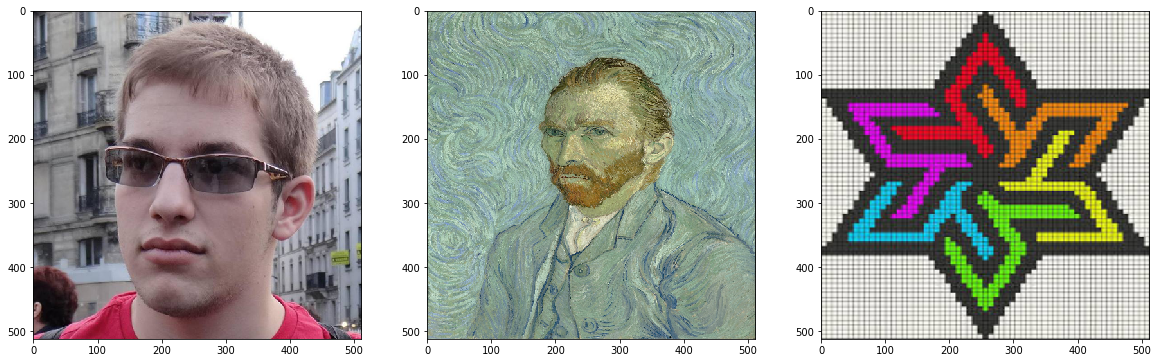

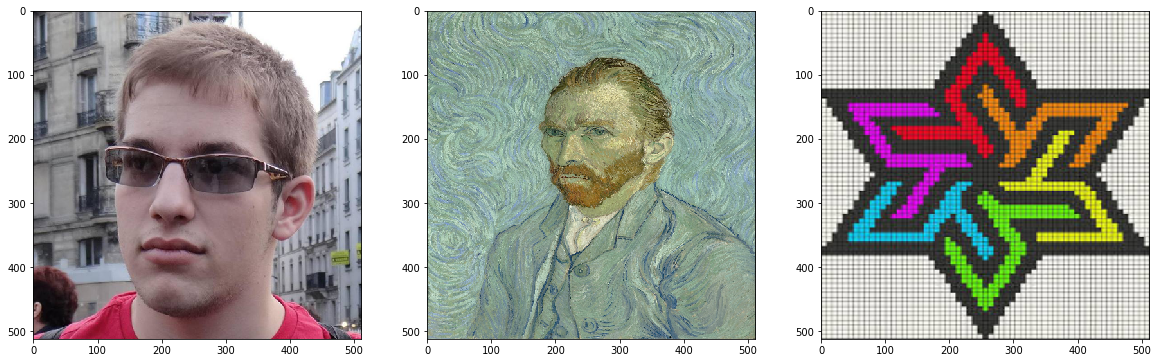

In [7]:
content,content_preprocessed = load_image(content_filename,shape)
starry_night,starry_night_preprocessed = load_image(starry_filename,shape)
retro,retro_preprocessed = load_image(retro_filename,shape)

fig,ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(content/255)
ax[1].imshow(starry_night/255)                      
ax[2].imshow(retro/255)                      

fig,ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(deprocess(content_preprocessed))
ax[1].imshow(deprocess(starry_night_preprocessed))                      
ax[2].imshow(deprocess(retro_preprocessed))                      


In [8]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)
    
def mse(layer,target):
    return K.mean((layer-target)**2)

def solve_image(eval_obj, niter, x,name,iq):
    for i in tqdm.tqdm(list(range(niter))):
        x, min_val, info = scipy.optimize.fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
#        imageio.imwrite("results/{}_at_iteration_{}.png".format(name,i), 
#                        (deprocess(join_yiq_to_bgr(x.reshape(shape),iq))*255).astype(np.uint8))
    return x

def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    the_dot = K.dot(features, K.transpose(features))
    tensor = tf.cast(K.prod(x.get_shape()[1:3]),tf.float32)
    num_elems = tensor
    return the_dot / num_elems

def style_loss(x, targ): 
    return mse(gram_matrix(x), gram_matrix(targ))

def style_transfer(input_content,input_style,content_multiplier,name,iq): 
    input_content = np.expand_dims(input_content,0)
    input_style = np.expand_dims(input_style,0)
    
    content_model = keras.Model(model.input, content_layers)
    style_model = keras.Model(model.input, style_layers)

    content_targets = [K.variable(output) for output in content_model.predict(input_content)]
    style_targets = [K.variable(output) for output in style_model.predict(input_style)]    
    
    style_losses = [style_loss(layer[0], target[0]) for layer,target in zip(style_layers, style_targets)]
    content_losses = [mse(layer, target) for layer,target in zip(content_layers, content_targets)]

    _style_loss = K.mean(K.stack(style_losses))
    content_loss = K.mean(K.stack(content_losses))
    
    loss = content_multiplier*content_loss + _style_loss
    
    grads = K.gradients(loss, model.input)
    fn = K.function([model.input], [loss]+grads)
    evaluator = Evaluator(fn, input_content.shape)
    
    x = input_content.copy()#np.random.uniform(-2.5, 2.5, [1]+list(shape))/100
    x = solve_image(evaluator, 100, x,name,iq)
    x = x.reshape(shape)

    fig,ax = plt.subplots(1,3,figsize=(20,10))
    ax[0].imshow(deprocess(join_yiq_to_bgr(input_content[0],iq)))
    ax[1].imshow(deprocess(join_yiq_to_bgr(input_style[0],iq)))                      
    ax[2].imshow(deprocess(join_yiq_to_bgr(x,iq)))       
    
    del evaluator, fn, grads, loss, content_targets,style_targets,content_model,style_model
    return x

  1%|          | 1/100 [00:12<20:05, 12.18s/it]

Current loss value: 6143712.5


  2%|▏         | 2/100 [00:22<18:24, 11.27s/it]

Current loss value: 1859537.25


  3%|▎         | 3/100 [00:32<17:45, 10.99s/it]

Current loss value: 848703.75


  4%|▍         | 4/100 [00:43<17:21, 10.85s/it]

Current loss value: 549310.0625


  5%|▌         | 5/100 [00:54<17:07, 10.81s/it]

Current loss value: 418727.96875


  6%|▌         | 6/100 [01:04<16:53, 10.78s/it]

Current loss value: 346604.71875


  7%|▋         | 7/100 [01:15<16:38, 10.73s/it]

Current loss value: 284291.25


  8%|▊         | 8/100 [01:25<16:25, 10.71s/it]

Current loss value: 247184.828125


  9%|▉         | 9/100 [01:36<16:12, 10.69s/it]

Current loss value: 207604.625


 10%|█         | 10/100 [01:46<16:01, 10.69s/it]

Current loss value: 183709.28125


 11%|█         | 11/100 [01:58<15:59, 10.78s/it]

Current loss value: 165375.28125


 12%|█▏        | 12/100 [02:09<15:47, 10.77s/it]

Current loss value: 150047.703125


 13%|█▎        | 13/100 [02:20<15:38, 10.78s/it]

Current loss value: 140784.125


 14%|█▍        | 14/100 [02:31<15:28, 10.80s/it]

Current loss value: 134510.84375


 15%|█▌        | 15/100 [02:41<15:17, 10.79s/it]

Current loss value: 128813.015625


 16%|█▌        | 16/100 [02:52<15:06, 10.79s/it]

Current loss value: 124368.7421875


 17%|█▋        | 17/100 [03:03<14:58, 10.82s/it]

Current loss value: 120648.6171875


 18%|█▊        | 18/100 [03:15<14:49, 10.84s/it]

Current loss value: 118008.8671875


 19%|█▉        | 19/100 [03:26<14:38, 10.85s/it]

Current loss value: 115376.921875


 20%|██        | 20/100 [03:37<14:29, 10.86s/it]

Current loss value: 112459.4375


 21%|██        | 21/100 [03:48<14:18, 10.87s/it]

Current loss value: 110006.0


 22%|██▏       | 22/100 [03:59<14:08, 10.87s/it]

Current loss value: 108003.0078125


 23%|██▎       | 23/100 [04:10<13:57, 10.88s/it]

Current loss value: 106385.8125


 24%|██▍       | 24/100 [04:21<13:47, 10.89s/it]

Current loss value: 105070.71875


 25%|██▌       | 25/100 [04:32<13:37, 10.90s/it]

Current loss value: 103859.09375


 26%|██▌       | 26/100 [04:43<13:27, 10.91s/it]

Current loss value: 102727.421875


 27%|██▋       | 27/100 [04:54<13:16, 10.92s/it]

Current loss value: 101559.390625


 28%|██▊       | 28/100 [05:05<13:06, 10.93s/it]

Current loss value: 100534.5


 29%|██▉       | 29/100 [05:17<12:56, 10.94s/it]

Current loss value: 98430.609375


 30%|███       | 30/100 [05:27<12:44, 10.93s/it]

Current loss value: 96584.9453125


 31%|███       | 31/100 [05:38<12:33, 10.92s/it]

Current loss value: 95786.890625


 32%|███▏      | 32/100 [05:49<12:22, 10.92s/it]

Current loss value: 95106.625


 33%|███▎      | 33/100 [06:00<12:12, 10.94s/it]

Current loss value: 94030.2421875


 34%|███▍      | 34/100 [06:12<12:02, 10.95s/it]

Current loss value: 92928.5078125


 35%|███▌      | 35/100 [06:23<11:52, 10.96s/it]

Current loss value: 91733.65625


 36%|███▌      | 36/100 [06:34<11:41, 10.97s/it]

Current loss value: 90715.3125


 37%|███▋      | 37/100 [06:45<11:31, 10.97s/it]

Current loss value: 89781.484375


 38%|███▊      | 38/100 [06:56<11:20, 10.97s/it]

Current loss value: 89052.8359375


 39%|███▉      | 39/100 [07:07<11:09, 10.97s/it]

Current loss value: 88080.265625


 40%|████      | 40/100 [07:18<10:58, 10.97s/it]

Current loss value: 87027.421875


 41%|████      | 41/100 [07:30<10:47, 10.98s/it]

Current loss value: 86058.234375


 42%|████▏     | 42/100 [07:40<10:36, 10.98s/it]

Current loss value: 85054.359375


 43%|████▎     | 43/100 [07:52<10:25, 10.98s/it]

Current loss value: 84251.421875


 44%|████▍     | 44/100 [08:03<10:14, 10.98s/it]

Current loss value: 83690.640625


 45%|████▌     | 45/100 [08:14<10:03, 10.98s/it]

Current loss value: 83137.25


 46%|████▌     | 46/100 [08:25<09:52, 10.98s/it]

Current loss value: 82634.390625


 47%|████▋     | 47/100 [08:36<09:42, 10.98s/it]

Current loss value: 81736.0390625


 48%|████▊     | 48/100 [08:46<09:30, 10.98s/it]

Current loss value: 81145.9765625


 49%|████▉     | 49/100 [08:58<09:20, 10.99s/it]

Current loss value: 80761.234375


 50%|█████     | 50/100 [09:09<09:09, 10.98s/it]

Current loss value: 80404.46875


 51%|█████     | 51/100 [09:20<08:58, 10.98s/it]

Current loss value: 80077.109375


 52%|█████▏    | 52/100 [09:31<08:47, 10.99s/it]

Current loss value: 79709.09375


 53%|█████▎    | 53/100 [09:42<08:36, 10.99s/it]

Current loss value: 79442.59375


 54%|█████▍    | 54/100 [09:53<08:25, 10.99s/it]

Current loss value: 79158.90625


 55%|█████▌    | 55/100 [10:04<08:14, 10.99s/it]

Current loss value: 78880.765625


 56%|█████▌    | 56/100 [10:15<08:03, 10.99s/it]

Current loss value: 78556.1953125


 57%|█████▋    | 57/100 [10:26<07:52, 10.99s/it]

Current loss value: 78293.03125


 58%|█████▊    | 58/100 [10:37<07:41, 10.99s/it]

Current loss value: 77825.578125


 59%|█████▉    | 59/100 [10:48<07:30, 10.98s/it]

Current loss value: 77422.4453125


 60%|██████    | 60/100 [11:00<07:20, 11.00s/it]

Current loss value: 77067.9453125


 61%|██████    | 61/100 [11:11<07:09, 11.01s/it]

Current loss value: 76840.78125


 62%|██████▏   | 62/100 [11:23<06:58, 11.02s/it]

Current loss value: 76607.578125


 63%|██████▎   | 63/100 [11:34<06:47, 11.02s/it]

Current loss value: 76354.46875


 64%|██████▍   | 64/100 [11:45<06:36, 11.02s/it]

Current loss value: 76094.1171875


 65%|██████▌   | 65/100 [11:56<06:25, 11.02s/it]

Current loss value: 75926.3671875


 66%|██████▌   | 66/100 [12:07<06:14, 11.02s/it]

Current loss value: 75753.1640625


 67%|██████▋   | 67/100 [12:18<06:03, 11.02s/it]

Current loss value: 75578.84375


 68%|██████▊   | 68/100 [12:29<05:52, 11.02s/it]

Current loss value: 75417.1796875


 69%|██████▉   | 69/100 [12:41<05:42, 11.03s/it]

Current loss value: 75243.5546875


 70%|███████   | 70/100 [12:52<05:30, 11.03s/it]

Current loss value: 75069.71875


 71%|███████   | 71/100 [13:03<05:19, 11.03s/it]

Current loss value: 74923.0625


 72%|███████▏  | 72/100 [13:14<05:09, 11.04s/it]

Current loss value: 74795.296875


 73%|███████▎  | 73/100 [13:25<04:57, 11.04s/it]

Current loss value: 74642.203125


 74%|███████▍  | 74/100 [13:36<04:47, 11.04s/it]

Current loss value: 74455.6796875


 75%|███████▌  | 75/100 [13:48<04:36, 11.04s/it]

Current loss value: 74323.953125


 76%|███████▌  | 76/100 [13:59<04:25, 11.05s/it]

Current loss value: 74193.96875


 77%|███████▋  | 77/100 [14:10<04:14, 11.05s/it]

Current loss value: 74034.5859375


 78%|███████▊  | 78/100 [14:21<04:03, 11.05s/it]

Current loss value: 73902.59375


 79%|███████▉  | 79/100 [14:33<03:52, 11.06s/it]

Current loss value: 73761.3515625


 80%|████████  | 80/100 [14:45<03:41, 11.06s/it]

Current loss value: 73609.2734375


 81%|████████  | 81/100 [14:56<03:30, 11.07s/it]

Current loss value: 73489.0


 82%|████████▏ | 82/100 [15:08<03:19, 11.08s/it]

Current loss value: 73314.375


 83%|████████▎ | 83/100 [15:20<03:08, 11.08s/it]

Current loss value: 73205.1484375


 84%|████████▍ | 84/100 [15:31<02:57, 11.09s/it]

Current loss value: 73094.546875


 85%|████████▌ | 85/100 [15:42<02:46, 11.09s/it]

Current loss value: 72943.21875


 86%|████████▌ | 86/100 [15:53<02:35, 11.09s/it]

Current loss value: 72806.75


 87%|████████▋ | 87/100 [16:05<02:24, 11.10s/it]

Current loss value: 72694.5546875


 88%|████████▊ | 88/100 [16:16<02:13, 11.09s/it]

Current loss value: 72589.0625


 89%|████████▉ | 89/100 [16:26<02:01, 11.09s/it]

Current loss value: 72444.6015625


 90%|█████████ | 90/100 [16:37<01:50, 11.09s/it]

Current loss value: 72297.7734375


 91%|█████████ | 91/100 [16:49<01:39, 11.09s/it]

Current loss value: 72189.5625


 92%|█████████▏| 92/100 [17:00<01:28, 11.09s/it]

Current loss value: 72079.515625


 93%|█████████▎| 93/100 [17:11<01:17, 11.09s/it]

Current loss value: 71985.953125


 94%|█████████▍| 94/100 [17:23<01:06, 11.10s/it]

Current loss value: 71889.4765625


 95%|█████████▌| 95/100 [17:35<00:55, 11.11s/it]

Current loss value: 71797.765625


 96%|█████████▌| 96/100 [17:46<00:44, 11.11s/it]

Current loss value: 71715.1796875


 97%|█████████▋| 97/100 [17:57<00:33, 11.11s/it]

Current loss value: 71609.6953125


 98%|█████████▊| 98/100 [18:08<00:22, 11.11s/it]

Current loss value: 71505.515625


 99%|█████████▉| 99/100 [18:19<00:11, 11.11s/it]

Current loss value: 71408.6953125


100%|██████████| 100/100 [18:30<00:00, 11.11s/it]

Current loss value: 71320.328125


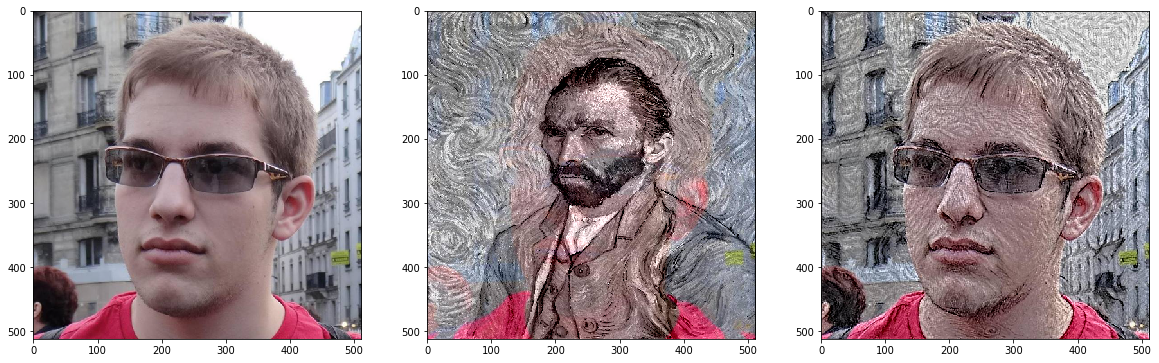

In [9]:
starry_luminance, content_luminance_starry, starry_iq = luminance_transfer(starry_night_preprocessed,content_preprocessed)


me_starry_night = style_transfer(content_luminance_starry,starry_luminance,1,"starry_night",starry_iq)

In [10]:
#retro_luminance, content_luminance_retro, retro_iq = luminance_transfer(retro_preprocessed,content_preprocessed)


#me_retro = style_transfer(content_luminance_retro,retro_luminance,0.5,"brazil_pixel",retro_iq)

(0.0, 1.0)

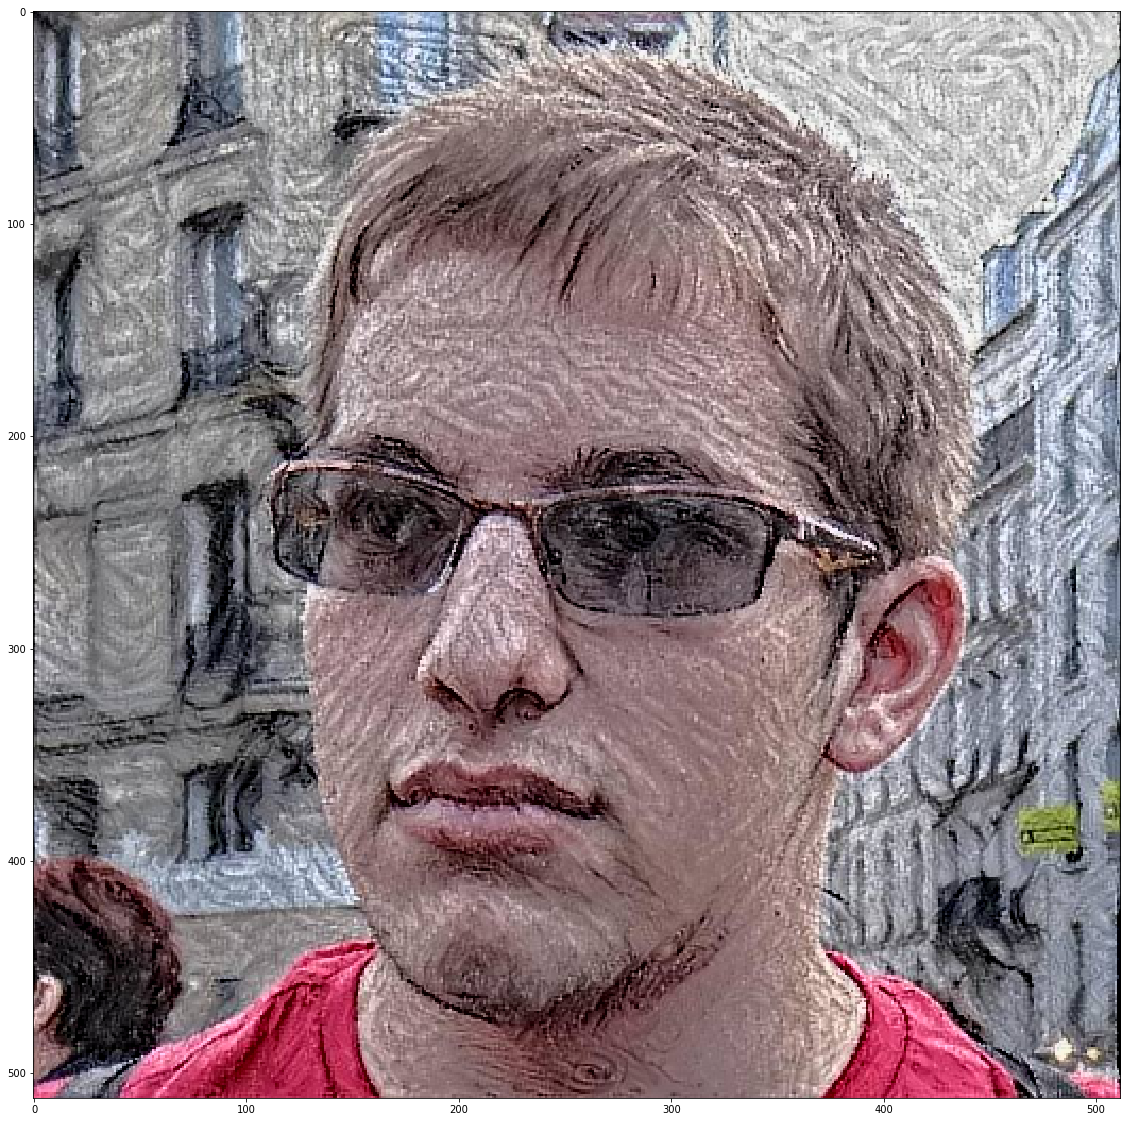

In [11]:
outImg = join_yiq_to_bgr(me_starry_night,starry_iq)
deprocessed = deprocess(outImg)
plt.figure(figsize=(20,20))
plt.imshow(deprocessed)
deprocessed.min(),deprocessed.max()